# EXTRACCIÓN DE DATOS Y PRETRATAMIENTO

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Los datos han sido extraídos del artículo de [Amaresh Mishra Dr., Markus K. R. Fischer Dipl.-Chem., Peter Bäuerle Prof. Dr.](https://onlinelibrary.wiley.com/doi/full/10.1002/anie.200804709)

In [2]:
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vRpQ_-OWXKsrAwqXnWYRhxGIV6fqigu1XLgoJMIdRCH4fdTW8AYtPt0-KkbI2gaiV-ITJH2Gouclfjg/pub?gid=0&single=true&output=csv')
data.head(10)

,ID,SMILES,J,V,FF,n,Ref
0,1,CN(C)c2ccc(/C(=C\C=C\C=C(C#N)\C(=O)O)c1ccc(N(C...,12.9,0.71,0.74,6.8,"39,41"
1,2,CCN(CC)c2ccc(/C(=C\C=C\C=C(C#N)\C(=O)O)c1ccc(N...,16.4,0.61,0.66,6.6,"39,41"
2,3,CN(C)c3ccc(/C(=C/c1ccc(/C=C(C#N)/C(=O)O)s1)c2c...,12.5,0.68,0.69,5.9,40
3,4,CC2(C)CC[N]1CCC(C)(C)c3c1c2cc4cc(/C=C/C=C(C#N)...,14.0,0.60,0.71,6.0,"42,45"
4,5,CC2(C)CC[N]1CCC(C)(C)c4c1c2cc5cc(/C=C\c3ccc(/C...,14.7,0.67,0.73,7.2,44
5,6,CC2(C)CC[N]1CCC(C)(C)c5c1c2cc6cc(c4ccc(c3ccc(/...,14.3,0.73,0.74,7.7,"37, 44, 46, 47"
6,7,CC2(C)CC[N]1CCC(C)(C)c5c1c2cc6cc(c4ccc(/C=C\c3...,15.9,0.69,0.75,8.2,48
7,8,CC2(C)CC[N]1CCC(C)(C)c5c1c2cc6cc(/C=C(C#N)/c4c...,18.8,0.53,0.65,6.5,49
8,9,CCCCCCc4cc(c3sc(c2sc(c1sc(/C=C(C#N)/C(=O)O)cc1...,14.0,0.74,0.74,7.7,"50,51"
9,10,CCCCCCc1cc(/C=C(C#N)/C(=O)O)sc1c7ccc(c6ccc(c5c...,10.2,0.67,0.64,4.4,51


In [7]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import RDConfig
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

In [9]:
# !pip install py3Dmol
import py3Dmol
def show(smi, style='stick'):
    smiles_to_mol = Chem.MolFromSmiles(smi)
    add_hs = Chem.AddHs(smiles_to_mol)
    AllChem.EmbedMolecule(add_hs)
    AllChem.MMFFOptimizeMolecule(add_hs, maxIters=200)
    mblock = Chem.MolToMolBlock(add_hs)

    view = py3Dmol.view(width=300, height=300)
    view.addModel(mblock, 'mol')
    view.setStyle({style:{}})
    view.zoomTo()
    view.show()
    
# example
show(data.SMILES[2])  # or 'P'

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

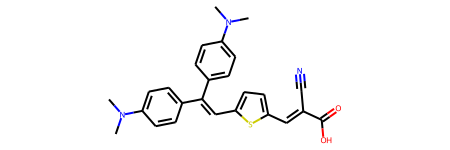

In [10]:
Chem.MolFromSmiles(data.SMILES[2])

## 